## Finding Groceries Using Fast R-CNN

This notebook demonstrates how to evaluate a single image using Fast R-CNN in CNTK.

Please make sure you have the latest Anaconda installed, and create a Python 3.4 environment using the provided `environment.yml` file. Take a look at the `README.md` for more detailed instructions.

Training the model is a time-consuming and GPU-intensive process which we've done separately in the cloud using several Python scripts, please see the [CNTK Fast R-CNN example](https://github.com/Microsoft/CNTK/tree/master/Examples/Image/Detection) or our [original code story](https://www.microsoft.com/developerblog/2017/07/31/using-object-detection-complex-image-classification-scenarios/) for details.

##### 1. Make sure that the model exists

First things first - we will make sure that the Fast-RCNN model file exists. The script will use your local trained model (if available), or will download and use the pre-trained model if a local trained model isn't available.

In [24]:
%matplotlib inline

import os
import sys
import cntk
from urllib.request import urlretrieve

# Reset this to your own path if you don't want it going into the current directory
root_dir = os.path.abspath(os.getcwd())
model_path = os.path.join(root_dir, 'Models', 'FastRCNN.model')
model_url = 'https://www.cntk.ai/Models/FRCN_Grocery/Fast-RCNN_grocery100.model'
if not os.path.exists(model_path):
    print('Downloading model from ' + model_url + ', may take a while...')
    urlretrieve(model_url, model_path)
    print('Saved model as ' + model_path)
else:
    print('CNTK model already available at ' + model_path)

CNTK model already available at C:\dev\git_ws\jupytercon2017\JupyterCon2017\Retail_ImageClassificationStockkeeping\Models\FastRCNN.model


##### 2. Load the model and prepare it for evaluation:

As a first step for using the Fast-RCNN model, we load the trained model file.

The trained model accepts 3 inputs: The image data, the bounding box (region of interest, or ROI) proposals and the ground truth labels of the ROIs. Since we are evaluating a new image - we probably don't have the ground truth labels for the image, hence - we need to adjust the network to accept  only the image and the ROIs as input.

In order to do that we use the CNTK APIs to clone the network and change its input nodes.

More information and examples regarding cloning nodes of a network are available in the <a href="https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_301_Image_Recognition_with_Deep_Transfer_Learning.ipynb" target="_blank">Transfer Learning</a> tutorial.

In [25]:
from cntk import load_model
from cntk import placeholder
from cntk.logging.graph import find_by_name, get_node_outputs
from cntk.ops import combine
from cntk.ops.sequence import input_variable
from cntk.ops.functions import CloneMethod

# load the trained model
trained_frcnn_model = load_model(model_path)

# find the original features and rois input nodes
features_node = find_by_name(trained_frcnn_model, "features")
rois_node = find_by_name(trained_frcnn_model, "rois")

#  find the final feature layer (named 'z')
z_node = find_by_name(trained_frcnn_model, 'z')

# define new input nodes for the features (image) and rois
image_input = input_variable(features_node.shape, name='features')
roi_input = input_variable(rois_node.shape, name='rois')

# Clone the desired layers with fixed weights and place holder for the new input nodes
cloned_nodes = combine([z_node.owner]).clone(
    CloneMethod.freeze,
    {features_node: placeholder(name='features'), rois_node: placeholder(name='rois')})

# apply the cloned nodes to the input nodes
frcnn_model = cloned_nodes(image_input, roi_input)

print("Fast-RCNN Grocery model loaded and cloned")

Fast-RCNN Grocery model loaded and cloned


##### 3. Load an image and convert it to the expected format

Next, we load an image from the test set using OpenCV, and then resize according to the network input dimensions. (Which are set when the network is trained).

When resizing, we preserve scale and pad the border areas with a constant value (114), which is later used for normalization by the network.

(-0.5, 999.5, 999.5, -0.5)

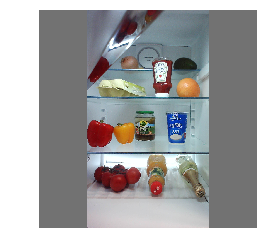

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_height = 1000
image_width = 1000 

def resize_and_pad(img, width, height, pad_value=114):
    img_height, img_width, _ = img.shape

    # Scale image by width else height
    if img_width > img_height:
        target_w = width
        target_h = int(np.round(img_height * width / float(img_width)))
    else:
        target_w = int(np.round(img_width * height / float(img_height)))
        target_h = height
        
    resized = cv2.resize(img, (target_w, target_h), 0, 0, interpolation=cv2.INTER_NEAREST)
    
    top = int(max(0, np.round((height - target_h) / 2.)))
    left = int(max(0, np.round((width - target_w) / 2.)))
    
    bottom = height - top - target_h
    right = width - left - target_w
    
    resized_with_pad = cv2.copyMakeBorder(resized, top, bottom, left, right, 
                                          cv2.BORDER_CONSTANT, value=[pad_value, pad_value, pad_value])

    #tranpose(2,0,1) converts the image to the HWC format which CNTK accepts
    model_arg_rep = np.ascontiguousarray(np.array(resized_with_pad, dtype=np.float32).transpose(2,0,1))
    
    return resized_with_pad, model_arg_rep

def load_image_and_scale(image_path, width, height, pad_value=114):
    img = cv2.imread(image_path)
    return resize_and_pad(img, width, height, pad_value), img

test_image_path = os.path.join(root_dir, 'Grocery/testImages/WIN_20160803_11_28_42_Pro.jpg')
(test_img, test_img_model_arg), original_img = load_image_and_scale(test_image_path, image_width, image_height)

plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

##### 4. Generate ROIs for testing

Now, we produce regions of interest (ROIs) proposals using selective search & grid methods, using custom C++ code published as part of the [Fast R-CNN GitHub](https://github.com/rbgirshick/fast-rcnn).

Each ROI is in the format of [x,y,w,h], where the coordinates real numbers in the range of 0 to 1, and scaled according to the resized and padded image. 

The ROIs array is padded with regions of [0,0,0,0] at the end to match the 100 ROIs expected by the model.

In [27]:
from cntk_helpers import imArrayWidthHeight, getSelectiveSearchRois, imresizeMaxDim
from cntk_helpers import getGridRois, filterRois, roiTransformPadScaleParams, roiTransformPadScale

# Constants - See CNTK Fast R-CNN Example for definitions
roi_min_dim_rel, roi_max_dim_rel = 0.04, 0.4
roi_min_nr_pixels_rel, roi_max_nr_pixels_rel = 2. * roi_min_dim_rel**2., 0.33 * roi_max_dim_rel**2.
roi_max_aspect, roi_max_img_dim = 4., 200
ss_scale, ss_sigma, ss_min_size = 100, 1.2, 20
grid_nr_scales, grid_aspects = 7, [1., 2., 0.5]
cntk_nr_rois, cntk_pad_width, cntk_pad_height = 100, 1000, 1000

def get_rois_for_image(img):
    roi_min_dim, roi_max_dim = roi_min_dim_rel * roi_max_img_dim, roi_max_dim_rel * roi_max_img_dim
    roi_min_nr_pixels, roi_max_nr_pixels = roi_min_nr_pixels_rel * roi_max_img_dim**2, roi_max_nr_pixels_rel * roi_max_img_dim**2
    img_orig = img.copy()

    # get rois
    print ("Calling selective search..")
    rects, scaled_img, scale = getSelectiveSearchRois(img_orig, ss_scale, ss_sigma, ss_min_size, roi_max_img_dim)
    print ("Number of rois detected using selective search: %d" % len(rects))
        
    # add grid rois
    scaled_width, scaled_height = imArrayWidthHeight(scaled_img)
    rects_grid = getGridRois(scaled_width, scaled_height, grid_nr_scales, grid_aspects)
    print ("Number of rois on grid added: %d" % len(rects_grid))
    rects += rects_grid

    # run filter
    print ("Number of rectangles before filtering  = %d" % len(rects))
    rois = filterRois(rects, scaled_width, scaled_height, roi_min_nr_pixels, roi_max_nr_pixels, roi_min_dim, roi_max_dim, roi_max_aspect)
    if len(rois) == 0: #make sure at least one roi returned per image
        rois = [[5, 5, scaled_width-5, scaled_height-5]]
    print ("Number of rectangles after filtering  = %d" % len(rois))

    # scale up to original size
    # note: each rectangle is in original image format with [x1,y1,x2,y2]
    original_rois = np.int32(np.array(rois) / scale)
    
    orig_height, orig_width, _ = img.shape
    # all rois need to be scaled + padded to cntk input image size
    targetw, targeth, w_offset, h_offset, scale = \
        roiTransformPadScaleParams(orig_width, orig_height, cntk_pad_width, cntk_pad_height)
    
    rois = []
    for original_roi in original_rois:
        x1, y1, x2, y2 = roiTransformPadScale(original_roi, w_offset, h_offset, scale)        
        rois.append([x1, y1, x2, y2])
    
    # pad or prune rois if needed:
    if len(rois) < cntk_nr_rois:
        rois += [[0, 0, 0, 0]] * (cntk_nr_rois - len(rois))
    elif len(rois) > cntk_nr_rois:
        rois = rois[:cntk_nr_rois]
    return np.array(rois), original_rois

test_rois, original_rois = get_rois_for_image(original_img)
roi_padding_index = len(original_rois)
print("Number of rois for evaluation: %d" % len(test_rois))

Calling selective search..
Number of rois detected using selective search: 242
Number of rois on grid added: 110580
Number of rectangles before filtering  = 110822
Number of rectangles after filtering  = 1338
Number of rois for evaluation: 100


##### 5. Evaluate the sample

Here, we prepare the data to be in CNTK's expected arguments format and run it through the model used the model's `eval` method.

We then process the result by trimming the padded ROIs, and calculate the predicted labels and their probabilities.

In [28]:
from cntk_helpers import softmax2D

# a dummy variable for labels the will be given as an input to the network but will be ignored
dummy_labels = np.zeros((2000,17))

#Index the names of the arguments so we can get them by name
args_indices = dict([(arg.name, i) for (i, arg) in enumerate(frcnn_model.arguments)])
    
# prepare the arguments
arguments = {
    frcnn_model.arguments[args_indices['features']]: [test_img_model_arg],
    frcnn_model.arguments[args_indices['rois']]: [np.float32(test_rois)],
}

# run it through the model
output = frcnn_model.eval(arguments)

# we now extract the features from the layer just before the softmax layer
rois_values = output[0][0][:roi_padding_index]

# get the prediction for each roi by taking the index with the maximal value in each row 
rois_labels_predictions = np.argmax(rois_values, axis=1)

# calculate the probabilities using softmax2D
rois_probs = softmax2D(rois_values)

# print the number of ROIs that were detected as non-background
print("Number of detections: %d" % np.sum(rois_labels_predictions > 0))

Number of detections: 28


##### 6. Merge overlapping regions using Non-Maxima-Suppression

Before inspecting the predictions, we need to merge overlapping regions that were detected using the Non-Maxima-Suppression algorithm that is implemented in the cntk_helpers module.

In [29]:
from cntk_helpers import applyNonMaximaSuppression
nms_threshold = 0.1
non_padded_rois = test_rois[:roi_padding_index]
max_probs = np.amax(rois_probs, axis=1).tolist()

rois_prediction_indices = applyNonMaximaSuppression(nms_threshold, rois_labels_predictions, max_probs, non_padded_rois, ignore_background=True)
print("Indices of selected regions:",rois_prediction_indices)

Indices of selected regions: [18, 30, 87, 37, 89, 17, 97, 41, 84]


### 8. Visualize the results

As a final step, we use the OpenCV **rectangle** and **putText** methods in order to draw the selected regions on the original image alongside their corresponding predicted labels.

Evaluation result:


(-0.5, 1079.5, 1919.5, -0.5)

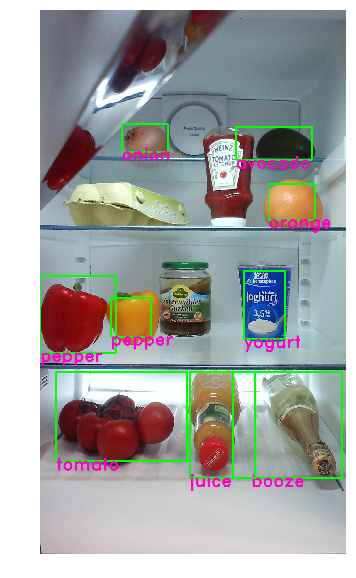

In [30]:
rois_with_prediction = test_rois[rois_prediction_indices]
rois_prediction_labels = rois_labels_predictions[rois_prediction_indices]
rois_predicion_scores = rois_values[rois_prediction_indices]
original_rois_predictions = original_rois[rois_prediction_indices]

classes = ('__background__',  # always index 0
           'avocado', 'orange', 'butter', '  booze', 'eggs', 'pickle', 'yogurt', 'ketchup',
           'juice', 'onion', 'pepper', 'tomato', 'water', 'milk', 'tabasco', 'mustard')

original_img_cpy = original_img.copy()

for roi,label in zip(original_rois_predictions, rois_prediction_labels):
    (x1,y1,x2,y2) = roi
    cv2.rectangle(original_img_cpy, (x1, y1), (x2, y2), (0, 255, 0), 5)
    cv2.putText(original_img_cpy,classes[label],(x1,y2 + 30), cv2.FONT_HERSHEY_DUPLEX, 2,(200,0,255),3,cv2.LINE_AA)

print("Evaluation result:")
plt.figure(figsize=(10, 10))    
plt.imshow(cv2.cvtColor(original_img_cpy, cv2.COLOR_BGR2RGB), interpolation='nearest')

plt.axis("off")